# IPCV Assignment 1

Authors:

- Mauro Dore             - mauro.dore@studio.unibo.it            - 0001105149
- Gian Mario Marongiu    - gianmario.marongiu@studio.unibo.it    - 0001092260
- Riccardo Murgia        - riccardo.murgia2@studio.unibo.it      - 0001083930

## Imports and Auxiliary Functions

In [1]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm


In [2]:
def show_multiple_images(image_list, cols=3, titles=None, global_title=None, plot_height=3):
    if not image_list:
        raise ValueError("The image list must not be empty.")

    num_images = len(image_list)

    if titles and len(titles) != num_images:
        raise ValueError("Titles list length must match the number of images.")

    rows = -(-num_images // cols)  # Equivalent to math.ceil

    fig, axes = plt.subplots(rows, cols, figsize=(10, plot_height * rows))
    fig.subplots_adjust(top=0.9 if global_title else 1.0)

    if global_title:
        fig.suptitle(global_title, fontsize=16, fontweight='bold')

    axes = axes.flatten() if num_images > 1 else [axes]

    for i, ax in enumerate(axes):
        if i < num_images:
            image = image_list[i]

            # Ensure the image is in an acceptable format (uint8)
            if image.dtype == np.float64:
                # Scale to 0-255 and convert to uint8
                image = np.uint8(np.clip(image * 255, 0, 255))

            # Handle both grayscale and color images
            if len(image.shape) == 2:  # Grayscale image (height, width)
                ax.imshow(image, cmap='gray')  # Use grayscale colormap for black-and-white images
            elif len(image.shape) == 3:  # Color image (height, width, channels)
                # Convert BGR to RGB if the image is in BGR format
                ax.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
            else:
                raise ValueError(f"Image at index {i} has invalid shape: {image.shape}")

            ax.set_axis_off()
            if titles:
                ax.set_title(titles[i], fontsize=12, fontweight='bold')
        else:
            ax.set_visible(False)

    plt.tight_layout()
    plt.show()


def compute_metrics(real_occurrences, predicted_occurrences):
    # Initialize variables to track TP, FP, FN
    true_positives = 0
    false_positives = 0
    false_negatives = 0

    # Iterate over each class/key in real occurrences
    for key in real_occurrences:
        real_set = set(real_occurrences[key])
        predicted_set = set(predicted_occurrences.get(key, []))

        # Compute true positives (correct predictions)
        tp = len(real_set & predicted_set)

        # Compute false positives (wrong predictions)
        fp = len(predicted_set - real_set)

        # Compute false negatives (missed real occurrences)
        fn = len(real_set - predicted_set)

        # Update counts
        true_positives += tp
        false_positives += fp
        false_negatives += fn

    # Calculate precision, recall, and F1 score
    precision = true_positives / (true_positives + false_positives) if true_positives + false_positives > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if true_positives + false_negatives > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if precision + recall > 0 else 0

    # Return the metrics
    return precision, recall, f1
    
def png_to_numpy(path, list):
    for image_name in os.listdir(path):
        image_path = os.path.join(path, image_name)
        image = cv2.imread(image_path)
        list.append(image)

def print_detection_summary(real_matchings, detected_matchings):
    print("Detection summary:")
    for scene in real_matchings.keys():
        scene_str = f"Scene {scene}".ljust(20)
        present_models_str = f"Models in the image: {real_matchings[scene]}".ljust(60)
        detected_models_str = f"Models detected: {detected_matchings[scene]}"
    
        print(f"{scene_str} {present_models_str} {detected_models_str}")


In [3]:
MODELS_SINGLE_INSTANCE_PATH = "models_single_instance"
SCENES_SINGLE_INSTANCE_PATH = "scenes_single_instance"
MODELS_MULTIPLE_INSTANCES_PATH = "models_multiple_instances"
SCENES_MULTIPLE_INSTANCES_PATH = "scenes_multiple_instances"

models_single_instance = []
scenes_single_instance = []
models_multiple_instances = []
scenes_multiple_instances = []

png_to_numpy(MODELS_SINGLE_INSTANCE_PATH, models_single_instance)
png_to_numpy(SCENES_SINGLE_INSTANCE_PATH, scenes_single_instance)
png_to_numpy(MODELS_MULTIPLE_INSTANCES_PATH, models_multiple_instances)
png_to_numpy(SCENES_MULTIPLE_INSTANCES_PATH, scenes_multiple_instances)
    
print(f"{len(models_single_instance)} models and {len(scenes_single_instance)} scenes for single instance detection task")
print(f"{len(models_multiple_instances)} models and {len(scenes_multiple_instances)} scenes for multiple instances detection task")


14 models and 5 scenes for single instance detection task
12 models and 7 scenes for multiple instances detection task


In [4]:
def warp_model(model, homography, scene_shape):
    """
    Warps the entire model to the scene based on the homography matrix.
    Ensures that the warped model stays within the scene boundaries.
    """
    height, width = model.shape[:2]

    # Get the corner points of the model
    model_corners = np.float32([[0, 0], [0, height - 1], [width - 1, height - 1], [width - 1, 0]]).reshape(-1, 1, 2)

    # Warp the corner points to the scene using the homography matrix
    warped_corners = cv2.perspectiveTransform(model_corners, homography)

    # Get the bounding box of the warped model
    x_min = int(min(warped_corners[:, 0, 0]))
    x_max = int(max(warped_corners[:, 0, 0]))
    y_min = int(min(warped_corners[:, 0, 1]))
    y_max = int(max(warped_corners[:, 0, 1]))

    # Ensure the bounding box is within the scene boundaries
    h_scene, w_scene = scene_shape[:2]
    x_min = max(0, x_min)
    x_max = min(w_scene, x_max)
    y_min = max(0, y_min)
    y_max = min(h_scene, y_max)

    # Warp the entire model to the scene size using homography
    warped_model = cv2.warpPerspective(model, homography, (w_scene, h_scene))

    # Crop the corresponding region from the warped model and scene
    return warped_model[y_min:y_max, x_min:x_max], (x_min, y_min, x_max, y_max)

def zncc(patch1, patch2):
    # Subtract the mean from each patch (Zero mean)
    patch1_mean = patch1 - np.mean(patch1)
    patch2_mean = patch2 - np.mean(patch2)

    # Compute the numerator: sum of element-wise products of the zero-mean patches
    numerator = np.sum(patch1_mean * patch2_mean)

    # Compute the denominator: product of the standard deviations
    denominator = np.sqrt(np.sum(patch1_mean ** 2) * np.sum(patch2_mean ** 2))

    # Avoid division by zero
    if denominator == 0:
        return -1  # Return -1 if denominator is 0

    return numerator / denominator

def validate_matching(model, scene, homography, config):
    """
    Validate by comparing the entire warped model with the corresponding region in the scene.
    """
    # Warp the model and get the corresponding region in the scene
    model_warped, (x_min, y_min, x_max, y_max) = warp_model(model, homography, scene.shape)

    # Extract the corresponding region from the scene
    scene_region = scene[y_min:y_max, x_min:x_max]

    # Compare the entire warped model and the scene region using ZNCC
    zncc_score = zncc(model_warped, scene_region)
    return zncc_score > config["zncc_threshold"]


def object_retrieve(model, scene, config):
    sift = cv2.SIFT_create(contrastThreshold=config["sift_contrast_threshold"],
                           edgeThreshold=config["sift_edge_threshold"],
                           sigma=config["sift_sigma"],
                           nOctaveLayers=config["sift_n_octave_layers"])

    # Detect keypoints and compute descriptors
    keypoints_model, descriptors_model = sift.detectAndCompute(model, None)
    keypoints_scene, descriptors_scene = sift.detectAndCompute(scene, None)

    # FLANN parameters for matching
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=config["flann_trees"])
    search_params = dict(checks=config["flann_checks"])
    flann = cv2.FlannBasedMatcher(index_params, search_params)

    # Match descriptors using k-NN (k=2)
    matches = flann.knnMatch(descriptors_model, descriptors_scene, k=2)

    # Lowe's ratio test to select good matches. m is first match, n is second match.
    good_matches = []
    for model_point, scene_point in matches:
        if model_point.distance < config["lowes_ratio_thresh"] * scene_point.distance:
            good_matches.append(model_point)

    # Ensure enough good matches were found
    if len(good_matches) < config["low_thresh_min_match"]:
        return False, scene, len(good_matches)

    # Extract coordinates from the good matches
    model_points = np.float32([keypoints_model[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    scene_points = np.float32([keypoints_scene[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

    # Find homography matrix
    homography, mask = cv2.findHomography(model_points, scene_points, cv2.RANSAC, 5.0)

    # Validate using zncc
    matching_exceeds_high_threshold = len(good_matches) > config["high_thresh_min_match"]
    matching_exceeds_low_threshold = len(good_matches) > config["low_thresh_min_match"]
    patch_check_is_valid = validate_matching(model, scene, homography, config)

    if matching_exceeds_high_threshold or (matching_exceeds_low_threshold and patch_check_is_valid):
        height, width = model.shape[:2]
        model_corners = np.float32([[0, 0], [0, height - 1], [width - 1, height - 1], [width - 1, 0]]).reshape(-1, 1, 2)
        dst = cv2.perspectiveTransform(model_corners, homography)
        scene_boxed = cv2.polylines(np.array(scene), [np.int32(dst)], True, (0, 255, 0), 5, cv2.LINE_AA)

        return True, scene_boxed, len(good_matches)
    else:
        return False, scene, len(good_matches)


## Multiple Instances Detection

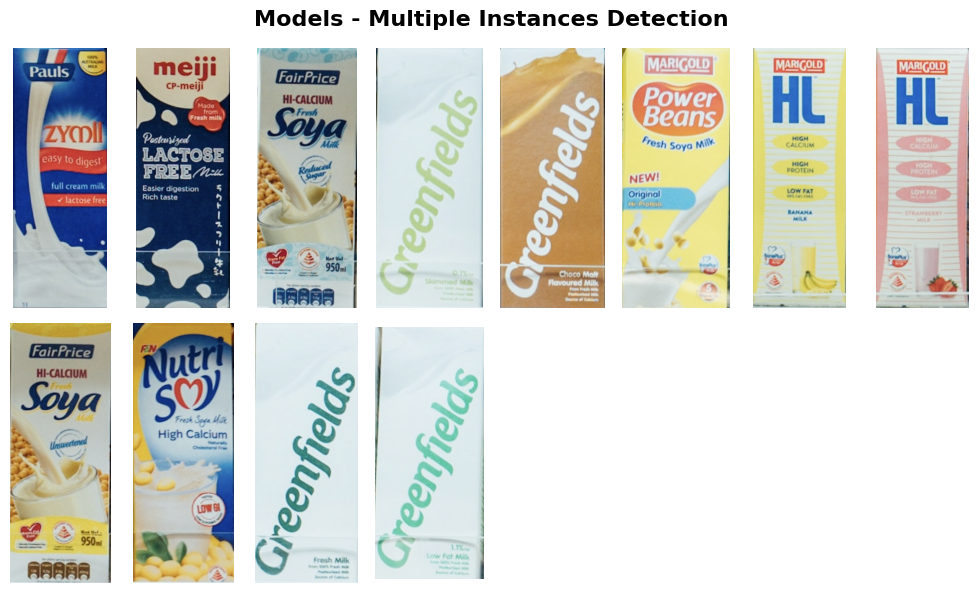

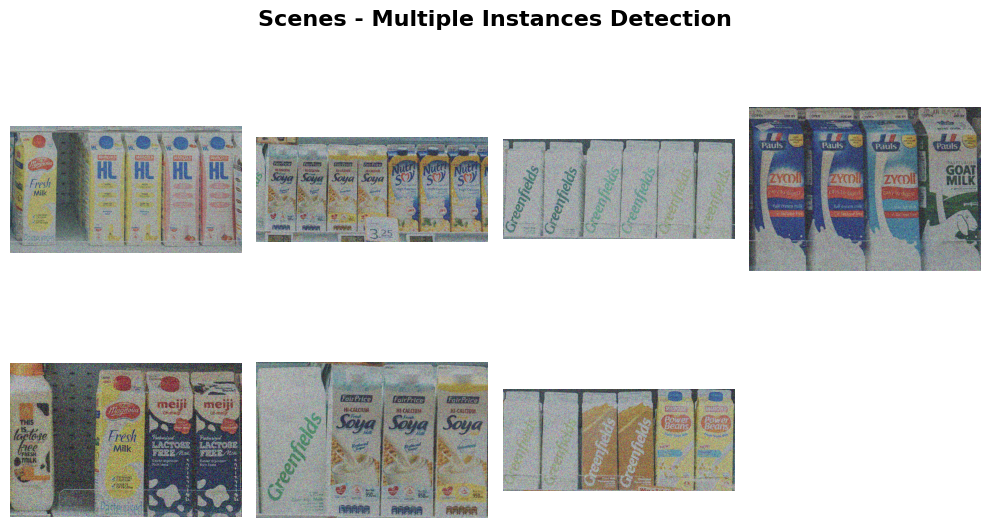

In [5]:
multi_instance_real_matchings = {0: [(6, 2), (7, 2)],
                                 1: [(2, 2), (8, 2), (9, 3)], 
                                 2: [(10, 2), (11, 2), (3, 2)], 
                                 3: [(0, 2)], 
                                 4: [(1, 2)], 
                                 5: [(2, 2), (8, 1)],
                                 6: [(3, 2), (4, 2), (5, 2)]}

show_multiple_images(models_multiple_instances, cols=8, global_title="Models - Multiple Instances Detection")
show_multiple_images(scenes_multiple_instances, cols=4, global_title="Scenes - Multiple Instances Detection")


In [6]:
def load_np_images(path):
    image_list = []
    for image_name in os.listdir(path):
        image_path = os.path.join(path, image_name)
        image = cv2.imread(image_path)
        image_list.append(image)
    return image_list

def denoise_images(images):
    denoised_images = []
    for image in images:
        denoised_images.append(denoising_pipeline(image))
    return denoised_images

def compute_edges(images):
    edges_list = []

    for image in images:
        edges = cv2.Canny(image, 150, 220)
        edges_list.append(edges)

    return edges_list

def process_scenes(images):
    processed_images = []

    for image in images:
        image_normalized = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX)
        image_uint8 = np.uint8(image_normalized)
        image_gray = cv2.cvtColor(image_uint8, cv2.COLOR_BGR2GRAY)

        processed_images.append(image_gray)

    return processed_images

def process_models_bw(images):
    processed_images = []

    for image in images:
        image_blurred = denoising_pipeline(image)
        image_normalized = cv2.normalize(image_blurred, None, 0, 255, cv2.NORM_MINMAX)
        image_uint8 = np.clip(image_normalized, 0, 255).astype(np.uint8)
        image = cv2.cvtColor(image_uint8, cv2.COLOR_BGR2GRAY)

        processed_images.append(image)

    return processed_images

def process_models_rgb(images):
    blurred_images = []
    for image in images:       
        image_blurred = denoising_pipeline(image)
        image_normalized = cv2.normalize(image_blurred, None, 0, 255, cv2.NORM_MINMAX)
        image_uint8 = np.clip(image_normalized, 0, 255).astype(np.uint8)
        blurred_images.append(image_uint8)
    return blurred_images

def compute_gradient_direction(edges, images):
    gradient_directions = []

    for image, mask in zip(images, edges):
        mask = (mask/255)
        grad_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=5)
        grad_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=5)
        gradient_direction = np.degrees(np.arctan2(grad_y, grad_x)+np.pi)
        gradient_direction_masked = mask*gradient_direction

        gradient_directions.append(gradient_direction_masked)

    return gradient_directions

# todo: MODIFICAMI
def denoising_pipeline(image):    
    denoised_image = cv2.medianBlur(image, 3)
    denoised_image = cv2.medianBlur(denoised_image, 3)
    denoised_image = cv2.bilateralFilter(denoised_image, d=19, sigmaColor=50, sigmaSpace=250)
    denoised_image = cv2.bilateralFilter(denoised_image, d=19, sigmaColor=20, sigmaSpace=100)
    return denoised_image


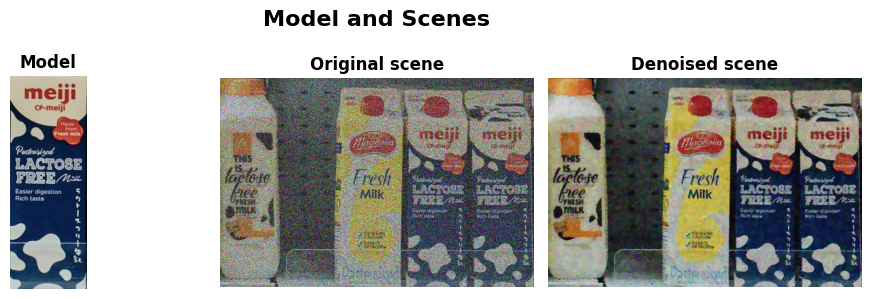

In [7]:
MODELS_MULTIPLE_INSTANCES_PATH = "models_multiple_instances"
SCENES_MULTIPLE_INSTANCES_PATH = "scenes_multiple_instances"

images = {
    "scenes": {
        "original_images" : None,
        "denoised_images" : None
    },
    "models": {
        "original_images" : None
    }
}

images['scenes']['original_images'] = load_np_images(SCENES_MULTIPLE_INSTANCES_PATH)
images['scenes']['denoised_images'] = denoise_images(images['scenes']['original_images'])
images['models']['original_images'] = load_np_images(MODELS_MULTIPLE_INSTANCES_PATH)

model_idx = 1
scene_idx = 4

show_multiple_images([images['models']['original_images'][model_idx],
                      images['scenes']['original_images'][scene_idx],
                      images['scenes']['denoised_images'][scene_idx]],
                      cols=3,
                      global_title="Model and Scenes",
                      titles=["Model", "Original scene", "Denoised scene"])


### Detection With Keypoints (No clustering)

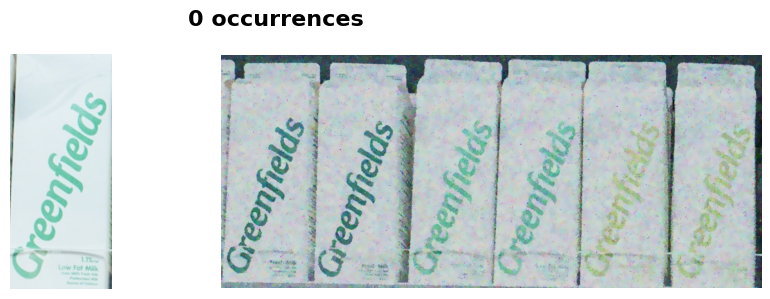

In [8]:
def multi_object_retrieve(model, scene, config):
    sift = cv2.SIFT_create(contrastThreshold=config["sift_contrast_threshold"],
                           edgeThreshold=config["sift_edge_threshold"],
                           sigma=config["sift_sigma"],
                           nOctaveLayers=config["sift_n_octave_layers"])
    
    # Detect keypoints and compute descriptors
    keypoints_model, descriptors_model = sift.detectAndCompute(model, None)
    keypoints_scene, descriptors_scene = sift.detectAndCompute(scene, None)
    
    # FLANN parameters for matching
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=config["flann_trees"])
    search_params = dict(checks=config["flann_checks"])
    flann = cv2.FlannBasedMatcher(index_params, search_params)

    # Match descriptors using k-NN
    matches = flann.knnMatch(descriptors_model, descriptors_scene, k=config["k_matches"])
    
    good_matches = []
    for match in matches:
        for match_point_idx in range(config["k_matches"]-1):
            m = match[match_point_idx]
            n = match[match_point_idx+1]
            
            if m.distance < config["lowes_ratio_thresh"] * n.distance:
                good_matches.append(m)
    
    model_keypoints = np.float32([keypoints_model[m.queryIdx].pt for m in good_matches]).reshape(-1, 2)
    scene_keypoints = np.float32([keypoints_scene[m.trainIdx].pt for m in good_matches]).reshape(-1, 2)
    
    occurrences_found = 0
    scene_boxed = scene.copy()
    
    # homography calculation requires at least 4 points for computation
    while len(model_keypoints) > 4:
        #print(f"There are {len(scene_keypoints)} good matches")
        homography, mask = cv2.findHomography(model_keypoints, scene_keypoints, cv2.RANSAC, 5.0)
        
        if homography is None:
            break
    
        # Validate using zncc
        matching_points_exceeds_threshold = len(scene_keypoints) > config["threshold_matches"]
        patch_is_valid = validate_matching(model, scene, homography, config)
    
        if matching_points_exceeds_threshold and patch_is_valid:
            height, width = model.shape[:2]
            model_corners = np.float32([[0, 0], [0, height - 1], [width - 1, height - 1], [width - 1, 0]]).reshape(-1, 1, 2)
            dst = cv2.perspectiveTransform(model_corners, homography)
            scene_boxed = cv2.polylines(scene_boxed, [np.int32(dst)], True, (0, 255, 0), 5, cv2.LINE_AA)
            occurrences_found += 1
            
            mask = mask.squeeze().astype("bool")
            scene_keypoints = scene_keypoints[~mask]
            model_keypoints = model_keypoints[~mask]
        else:
            break
        #print()
            
    if occurrences_found > 0:
        return True, scene_boxed, occurrences_found
    else:
        return False, scene, 0


# todo: MODIFICAMI
config_multi_instance = {
    # sift parameters
    "sift_contrast_threshold": 0.03,
    "sift_edge_threshold": 15,
    "sift_sigma": 1.5,
    "sift_n_octave_layers": 3,

    # flann parameters
    "flann_trees": 12,
    "flann_checks": 80,

    # feature matching parameters
    "threshold_matches": 10,
    "lowes_ratio_thresh": 0.8,
    "k_matches": 2,

    # Zero normalized cross-correlation parameters
    "zncc_threshold": 0.6
}

model_idx = 11   # 3, 8, 3, 0, 11, 8
scene_idx = 2    # 6, 5, 2, 3, 5, 1

model = images["models"]["original_images"][model_idx]
scene = images["scenes"]["denoised_images"][scene_idx]

found, scene_boxed, n_occurrences = multi_object_retrieve(model, scene, config_multi_instance)
show_multiple_images([model, scene_boxed], cols=2, global_title=f"{n_occurrences} occurrences")

In [9]:
multi_model_scene_couples = []
multi_instance_detected_matchings = {scene: [] for scene in range(len(scenes_multiple_instances))}

total_iterations = len(images["models"]["original_images"]) * len(images["scenes"]["original_images"])
with tqdm(total=total_iterations, desc="Processing Models and Scenes") as pbar:
    for model_idx, model in enumerate(images["models"]["original_images"]):
        for scene_idx, scene in enumerate(images["scenes"]["denoised_images"]):
            
            found, scene_boxed, n_occurrences = multi_object_retrieve(model=model, scene=scene, config=config_multi_instance)
            multi_model_scene_couples.append([model, scene_boxed, found, n_occurrences])

            if found:
                multi_instance_detected_matchings[scene_idx].append((model_idx, n_occurrences))

            pbar.update(1)

print_detection_summary(multi_instance_real_matchings, multi_instance_detected_matchings)
precision, recall, f1 = compute_metrics(multi_instance_real_matchings, multi_instance_detected_matchings)

print("\nPrecision: ", precision)
print("Recall: ", recall)
print("F1: ", f1)


Processing Models and Scenes:   7%|▋         | 6/84 [00:04<00:55,  1.40it/s]C:\Users\gianm\Desktop\Magistrale\Anno 1\Semestre 2\Computer vision\assignments\Instance_Detection\.venv\lib\site-packages\numpy\_core\fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\gianm\Desktop\Magistrale\Anno 1\Semestre 2\Computer vision\assignments\Instance_Detection\.venv\lib\site-packages\numpy\_core\_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
Processing Models and Scenes: 100%|██████████| 84/84 [00:58<00:00,  1.43it/s]

Detection summary:
Scene 0              Models in the image: [(6, 2), (7, 2)]                        Models detected: [(6, 2), (7, 2)]
Scene 1              Models in the image: [(2, 2), (8, 2), (9, 3)]                Models detected: [(2, 2), (8, 1), (9, 3)]
Scene 2              Models in the image: [(10, 2), (11, 2), (3, 2)]              Models detected: [(10, 1)]
Scene 3              Models in the image: [(0, 2)]                                Models detected: [(0, 3)]
Scene 4              Models in the image: [(1, 2)]                                Models detected: [(1, 2)]
Scene 5              Models in the image: [(2, 2), (8, 1)]                        Models detected: [(1, 1), (2, 3), (8, 3)]
Scene 6              Models in the image: [(3, 2), (4, 2), (5, 2)]                Models detected: [(4, 2), (5, 1)]

Precision:  0.46153846153846156
Recall:  0.4
F1:  0.42857142857142855


In [10]:
PLOT_ALL_IMAGES = False

if PLOT_ALL_IMAGES:
    for model, scene, found, good_matches in multi_model_scene_couples:
        if found > 0:
            show_multiple_images([model, scene], cols=2, global_title=f"Object Found - {good_matches} occurrences")
        else:
            show_multiple_images([model, scene], cols=2, global_title=f"Object not found")
            